# Prerequistes

- In order to download ALL card scans we'll setup mtg-bulk-database with postgres and then update ./.env with credentials:

https://github.com/JakeTurner616/mtg-bulk-database

In [ ]:
# Cell 1: Install required libraries (if not already installed)
%pip install numpy opencv-python h5py faiss-cpu sqlite3 matplotlib
%pip install  psycopg2 dotenv
%pip install aiohttp

In [ ]:
#!/usr/bin/env python3
import os
import json
import time
import asyncio
import aiohttp
import psycopg2
import psycopg2.extras
import sqlite3
from dotenv import load_dotenv
import nest_asyncio
from tqdm.asyncio import tqdm_asyncio  # Asynchronous progress bar

# Apply nest_asyncio to allow nested event loops (fixes the RuntimeError)
nest_asyncio.apply()

# ---------------------------
# CONFIGURATION
# ---------------------------
load_dotenv('.env')
DB_USER = os.getenv("POSTGRES_USER")
DB_PASSWORD = os.getenv("POSTGRES_PASSWORD")
DB_NAME = os.getenv("POSTGRES_DB")
DB_HOST = os.getenv("POSTGRES_HOST", "localhost")
DB_PORT = os.getenv("POSTGRES_PORT", "5432")

IMAGES_DIR = "images"
if not os.path.exists(IMAGES_DIR):
    os.makedirs(IMAGES_DIR)

# Pre-scan images directory to build a cache of existing files
existing_images = set(os.listdir(IMAGES_DIR))

RATE_LIMIT_DELAY = 0.2  # seconds for image downloads

# A semaphore to limit concurrent network requests for image downloads
rate_limit_semaphore = asyncio.Semaphore(10)

# ---------------------------
# DATABASE FUNCTIONS
# ---------------------------
def connect_postgres():
    conn = psycopg2.connect(
        dbname=DB_NAME,
        user=DB_USER,
        password=DB_PASSWORD,
        host=DB_HOST,
        port=DB_PORT
    )
    return conn

def query_cards(conn):
    """
    Query cards that meet the criteria:
      - layout is not 'art_series'
      - games JSONB column contains "paper"
      - language is English (lang = 'en')
    """
    query = """
        SELECT id, name, image_uris, card_faces, legalities, prints_search_uri, oracle_id, image_status
        FROM cards
        WHERE layout != 'art_series'
          AND games @> '["paper"]'
          AND lang = 'en'
    """
    with conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor) as cur:
        cur.execute(query)
        return cur.fetchall()

def ensure_sqlite_db(db_path='resources/run/card_database.db'):
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    # Create the table without the "reprint" field
    cur.execute("""
        CREATE TABLE IF NOT EXISTS cards (
            scryfall_id TEXT,
            name TEXT,
            image_path TEXT,
            face_index INTEGER,
            PRIMARY KEY(scryfall_id, face_index)
        )
    """)
    conn.commit()
    conn.close()

# ---------------------------
# HELPER FUNCTIONS
# ---------------------------
def get_file_extension(url):
    return ".png" if "png" in url.lower() else ".jpg"

def file_exists(card_id, face_index, ext):
    # Checks the in-memory cache of filenames
    filename = f"{card_id}_{face_index}{ext}"
    return filename in existing_images

async def download_image(session, url, filepath):
    """Download an image asynchronously with rate limiting."""
    async with rate_limit_semaphore:
        await asyncio.sleep(RATE_LIMIT_DELAY)
        try:
            async with session.get(url, timeout=10) as response:
                if response.status == 200:
                    content = await response.read()
                    with open(filepath, 'wb') as f:
                        f.write(content)
                    # Update the cache with the new file
                    existing_images.add(os.path.basename(filepath))
                    return True
                else:
                    print(f"Failed to download {url} (status {response.status})")
        except Exception as e:
            print(f"Exception downloading {url}: {e}")
    return False

# ---------------------------
# ASYNCHRONOUS CARD PROCESSING
# ---------------------------
# Global set and lock for tracking processed oracle_ids (used for grouping, if needed)
processed_oracles = set()
processed_oracles_lock = asyncio.Lock()

async def process_card(session, card):
    """
    Process a single card by downloading its image(s).
    We assume that all alternate printings share the same oracle_id.
    (If you don't need to differentiate between them, you can simply download each card.)
    Cards with image_status 'placeholder' are skipped.
    Returns a list of mapping dictionaries.
    """
    mappings = []
    card_id = card["id"]
    card_name = card["name"]
    
    # Skip card if its image_status is 'placeholder'
    if card.get("image_status", "").lower() == "placeholder":
        return mappings

    async def process_face(face, face_index):
        nonlocal mappings
        url = None
        # Use the face's image_uris if available, otherwise fallback to top-level image_uris.
        if face.get("image_uris"):
            url = face["image_uris"].get("png") or face["image_uris"].get("large")
        else:
            url = card.get("image_uris", {}).get("png") or card.get("image_uris", {}).get("large")
        if url:
            ext = get_file_extension(url)
            filename = f"{card_id}_{face_index}{ext}"
            filepath = os.path.join(IMAGES_DIR, filename)
            if not file_exists(card_id, face_index, ext):
                downloaded = await download_image(session, url, filepath)
                if downloaded:
                    mappings.append({
                        "card_id": card_id,
                        "card_name": card_name,
                        "image_path": filepath,
                        "face_index": face_index
                    })
            else:
                mappings.append({
                    "card_id": card_id,
                    "card_name": card_name,
                    "image_path": filepath,
                    "face_index": face_index
                })

    # Process all faces of the card
    if card.get("card_faces"):
        tasks = [process_face(face, idx) for idx, face in enumerate(card["card_faces"])]
        await asyncio.gather(*tasks)
    else:
        await process_face(card, 0)
    return mappings

async def process_all_cards(cards, max_concurrent=100):
    """Process all cards asynchronously while showing progress."""
    mappings = []
    connector = aiohttp.TCPConnector(limit=max_concurrent)
    async with aiohttp.ClientSession(connector=connector) as session:
        tasks = [process_card(session, card) for card in cards]
        for future in tqdm_asyncio.as_completed(tasks, total=len(tasks), desc="Processing cards"):
            try:
                card_mappings = await future
                mappings.extend(card_mappings)
            except Exception as e:
                print(f"Error processing a card: {e}")
    return mappings

# ---------------------------
# SQLITE UPDATE FUNCTION
# ---------------------------
def update_sqlite_batch(mappings, db_path='resources/run/card_database.db', chunk_size=1000):
    """Perform a bulk insert or replace into the SQLite database in chunks with progress indication."""
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    sql = """
        INSERT OR REPLACE INTO cards (scryfall_id, name, image_path, face_index)
        VALUES (?, ?, ?, ?)
    """
    data = [
        (m["card_id"], m["card_name"], m["image_path"], m["face_index"])
        for m in mappings
    ]
    total = len(data)
    from tqdm import tqdm
    for i in tqdm(range(0, total, chunk_size), desc="Updating SQLite"):
        chunk = data[i:i+chunk_size]
        cur.executemany(sql, chunk)
        conn.commit()
    conn.close()
    print(f"Updated/Inserted {total} records into SQLite.")

# ---------------------------
# EXTRA ENTRIES UPDATE FUNCTION
# ---------------------------
def update_extra_entries(extra_entries, db_path='resources/run/card_database.db'):
    """
    Insert extra testing entries into SQLite if they do not already exist.
    Displays progress for each entry.
    Each extra entry is a tuple: (scryfall_id, image_path, face_index)
    """
    from tqdm import tqdm
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    for scryfall_id, image_path, face_index in tqdm(extra_entries, desc="Updating extra entries", unit="entry"):
        if not scryfall_id or not image_path:
            print(f"Skipping incomplete extra entry: scryfall_id={scryfall_id}, image_path={image_path}")
            continue
        cur.execute("SELECT COUNT(*) FROM cards WHERE image_path = ?", (image_path,))
        exists = cur.fetchone()[0]
        if exists == 0:
            # For extra entries we use a simple fallback for card_name
            card_name = scryfall_id  
            cur.execute("""
                INSERT INTO cards (scryfall_id, name, image_path, face_index)
                VALUES (?, ?, ?, ?)
            """, (scryfall_id, card_name, image_path, face_index))
        else:
            print(f"Entry for {image_path} already exists, skipping insertion.")
    conn.commit()
    conn.close()

# ---------------------------
# CLEANUP FUNCTION
# ---------------------------
def cleanup_invalid_cards(valid_ids, sqlite_db_path='resources/run/card_database.db', images_dir=IMAGES_DIR):
    """
    Delete rows from the SQLite database and files from the filesystem
    for any card whose scryfall_id is not in the valid_ids set.
    Displays progress for both operations.
    """
    from tqdm import tqdm
    # Cleanup SQLite rows individually with progress indication
    conn = sqlite3.connect(sqlite_db_path)
    cur = conn.cursor()
    cur.execute("SELECT scryfall_id FROM cards")
    all_ids = [row[0] for row in cur.fetchall()]
    invalid_ids = [card_id for card_id in all_ids if card_id not in valid_ids]
    for card_id in tqdm(invalid_ids, desc="Cleaning up SQLite rows"):
        cur.execute("DELETE FROM cards WHERE scryfall_id = ?", (card_id,))
    conn.commit()
    conn.close()
    print("Cleaned up invalid rows from SQLite.")

    # Cleanup filesystem files with progress indication
    files = os.listdir(images_dir)
    for filename in tqdm(files, desc="Cleaning up image files"):
        parts = filename.split("_")
        if len(parts) < 2:
            continue
        card_id = parts[0]
        if card_id not in valid_ids:
            try:
                os.remove(os.path.join(images_dir, filename))
                print(f"Removed file {filename} as card_id {card_id} is invalid.")
            except Exception as e:
                print(f"Error removing file {filename}: {e}")

# ---------------------------
# MAIN FUNCTION
# ---------------------------
def main():
    # Ensure SQLite database and schema exist
    ensure_sqlite_db(db_path='resources/run/card_database.db')
    
    # Query cards from PostgreSQL
    print("Connecting to Postgres DB...")
    pg_conn = connect_postgres()
    print("Querying cards...")
    cards = query_cards(pg_conn)
    pg_conn.close()
    print(f"Found {len(cards)} cards in PostgreSQL.")
    
    # Optional hard limit (set via environment variable DATASET_LIMIT)
    limit = os.getenv("DATASET_LIMIT")
    if limit:
        try:
            limit = int(limit)
            cards = cards[:limit]
            print(f"Limiting automatic dataset to the first {limit} cards.")
        except Exception as e:
            print(f"Invalid DATASET_LIMIT value, proceeding without a limit. Error: {e}")

    # INITIAL CLEANUP: Remove any local rows and images that don't match the valid set from PostgreSQL.
    valid_ids_initial = {card["id"] for card in cards}
    cleanup_invalid_cards(valid_ids_initial, sqlite_db_path='resources/run/card_database.db', images_dir=IMAGES_DIR)
    
    # Process cards concurrently using asyncio
    mappings = asyncio.run(process_all_cards(cards, max_concurrent=100))
    print(f"Processing complete, total mappings: {len(mappings)}")
    
    # Update SQLite in chunks with progress indication
    update_sqlite_batch(mappings, db_path='resources/run/card_database.db', chunk_size=1000)
    
    # OPTIONAL: Process extra entries for testing (these are added regardless of the dataset limit)
    EXTRA_ENTRIES = [
        ("38748fbe-0d3e-4697-b9c4-d93a4ac59f9a", "images/38748fbe-0d3e-4697-b9c4-d93a4ac59f9a_0.png", 0),
        ("04a09fe4-d7a0-4065-968d-0837c3eafda0", "images/04a09fe4-d7a0-4065-968d-0837c3eafda0_0.png", 0),
        ("b462e121-015c-49c4-838a-ab788f213322", "images/b462e121-015c-49c4-838a-ab788f213322_0.png", 0),
        ("b1986db3-dd6c-44f2-8d7a-a6b42d55a7c1", "images/b1986db3-dd6c-44f2-8d7a-a6b42d55a7c1_0.png", 0),
        ("63c5e1dd-2fe6-4734-8406-7bcdf17aa60c", "images/63c5e1dd-2fe6-4734-8406-7bcdf17aa60c_0.png", 0),
        ("6c7cfb9c-58e4-4f4a-9a2c-ba5a7ba34f03", "images/6c7cfb9c-58e4-4f4a-9a2c-ba5a7ba34f03_0.png", 0),
        ("ee3768ec-bb3b-44dc-9fa3-7cb3d3ee9f8c", "images/ee3768ec-bb3b-44dc-9fa3-7cb3d3ee9f8c_0.png", 0),
        ("8321888a-a450-4c15-9461-255cfaa05367", "images/8321888a-a450-4c15-9461-255cfaa05367_0.png", 0),
        ("b5e8e2a9-8dcb-40dd-8079-6c8484c3b157", "images/b5e8e2a9-8dcb-40dd-8079-6c8484c3b157_0.png", 0)
    ]
    update_extra_entries(EXTRA_ENTRIES, db_path='resources/run/card_database.db')
    
    # FINAL CLEANUP: Remove any rows and images that don't match the processed valid mappings.
    valid_ids_final = {m["card_id"] for m in mappings}
    # Also include the extra entries' IDs
    valid_ids_final.update({entry[0] for entry in EXTRA_ENTRIES})
    cleanup_invalid_cards(valid_ids_final, sqlite_db_path='resources/run/card_database.db', images_dir=IMAGES_DIR)
    
    print("Workflow complete.")

if __name__ == "__main__":
    main()


# Feature extraction
- Preprocess  with CLAHE adjustments to the luminance channel, and convert back to the RGB color space
- Extract features using SIFT, apply RootSIFT normalization, and Product Quantization into an Inverted File Index
- ~~Generate a index_to_card.txt for robust searching of keypoints with RANSAC~~
- Add to existing model files instead of creating new ones each time

In [ ]:
import cv2
import numpy as np
import os
import json
import sqlite3
from tqdm import tqdm
import faiss
import h5py

#########################
# Candidate Features Extraction and HDF5 Storage (Incremental, with Chunking and High Compression)
#########################

def serialize_keypoints(keypoints):
    return [{
        'pt': kp.pt,
        'size': kp.size,
        'angle': kp.angle,
        'response': kp.response,
        'octave': kp.octave,
        'class_id': kp.class_id
    } for kp in keypoints]

def extract_features_sift(image_path, max_features=100):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Unable to read image {image_path}")
    
    # Resize and preprocess image.
    resized = cv2.resize(image, (256, 256))
    lab = cv2.cvtColor(resized, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    L_clahe = clahe.apply(L)
    lab_clahe = cv2.merge((L_clahe, A, B))
    enhanced_color = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)
    gray = cv2.cvtColor(enhanced_color, cv2.COLOR_BGR2GRAY)
    
    sift = cv2.SIFT_create(nfeatures=max_features)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    
    if descriptors is not None and len(keypoints) > max_features:
        sorted_kp_des = sorted(zip(keypoints, descriptors), key=lambda x: -x[0].response)
        keypoints, descriptors = zip(*sorted_kp_des[:max_features])
        keypoints, descriptors = list(keypoints), np.array(descriptors)
    
    if descriptors is not None:
        eps = 1e-7
        descriptors = descriptors / (descriptors.sum(axis=1, keepdims=True) + eps)
        descriptors = np.sqrt(descriptors)
        descriptors = descriptors.astype(np.float16)
    
    return keypoints, descriptors

# ---------------------------
# HDF5 File Setup (Incremental)
# ---------------------------
h5_features_file = 'resources/run/candidate_features.h5'
faiss_index_file = 'resources/run/faiss_ivf.index'

# Open the HDF5 file in append mode if it exists; otherwise create a new one.
if os.path.exists(h5_features_file):
    hf = h5py.File(h5_features_file, 'a')
    processed_ids = set(hf.keys())
else:
    hf = h5py.File(h5_features_file, 'w')
    processed_ids = set()

tqdm.write("Candidate features file opened in incremental mode.")

# ---------------------------
# Retrieve image records from SQLite.
# ---------------------------
db_path = 'resources/run/card_database.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()
cursor.execute('SELECT scryfall_id, image_path, face_index FROM cards')
rows = cursor.fetchall()
conn.close()

# Process only new records (cards not yet in the HDF5 file)
new_rows = [row for row in rows if row[0] not in processed_ids]
tqdm.write(f"Total records in DB: {len(rows)}; New records to process: {len(new_rows)}")

images_folder = 'images'
pbar = tqdm(total=len(new_rows), desc="Extracting features", unit="image")

# Extract and store features for new cards.
for scryfall_id, image_path, face_index in new_rows:
    full_image_path = os.path.join(images_folder, image_path)
    if not os.path.exists(full_image_path):
        full_image_path = image_path
    
    try:
        kp, des = extract_features_sift(full_image_path, max_features=100)
    except Exception as e:
        pbar.update(1)
        continue

    if des is None:
        pbar.update(1)
        continue

    kp_serialized = serialize_keypoints(kp)
    kp_json = json.dumps(kp_serialized)
    
    if scryfall_id in hf:
        card_grp = hf[scryfall_id]
    else:
        card_grp = hf.create_group(scryfall_id)
    
    feature_idx = len(card_grp)
    feat_grp = card_grp.create_group(f"feature_{feature_idx}")
    
    dt = h5py.string_dtype(encoding="utf-8")
    feat_grp.create_dataset("keypoints", data=[kp_json], dtype=dt,
                              compression="gzip", compression_opts=9, chunks=True)
    feat_grp.create_dataset("descriptors", data=des,
                              compression="gzip", compression_opts=9, chunks=True)
    
    pbar.update(1)
pbar.close()
hf.close()
tqdm.write(f"Candidate features written to HDF5 file: {h5_features_file}")

#########################
# Incremental FAISS Index Update
#########################

# If a FAISS index exists, load it; otherwise, train a new one from scratch.
if os.path.exists(faiss_index_file):
    index = faiss.read_index(faiss_index_file)
    index_loaded = True
    tqdm.write("Loaded existing FAISS index.")
else:
    # Rebuild the index from scratch using a sample from the HDF5 file.
    sample_size = 1000
    training_descriptors = []
    with h5py.File(h5_features_file, 'r') as hf:
        for card_id in hf.keys():
            card_grp = hf[card_id]
            for feat_key in card_grp.keys():
                des = card_grp[feat_key]["descriptors"][()]
                training_descriptors.append(des)
                if len(training_descriptors) >= sample_size:
                    break
            if len(training_descriptors) >= sample_size:
                break
    if len(training_descriptors) > 0:
        training_sample = np.vstack(training_descriptors).astype('float32')
    else:
        raise ValueError("No training descriptors available.")
    
    d = training_sample.shape[1]  # expected to be 128
    nlist = 100  # number of clusters
    m = 8       # number of subquantizers for PQ
    bits = 8    # bits per subquantizer
    quantizer = faiss.IndexFlatL2(d)
    index = faiss.IndexIVFPQ(quantizer, d, nlist, m, bits)
    index.nprobe = 10
    index.train(training_sample)
    tqdm.write("Trained new FAISS index with sample descriptors.")
    index_loaded = False

# Load existing mapping from SQLite for FAISS.
mapping_conn = sqlite3.connect(db_path)
mapping_cursor = mapping_conn.cursor()
mapping_cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='faiss_mapping'")
if mapping_cursor.fetchone() is None:
    mapping_cursor.execute("""
         CREATE TABLE faiss_mapping (
             faiss_index INTEGER PRIMARY KEY,
             scryfall_id TEXT NOT NULL
         )
    """)
    mapping_conn.commit()
    mapped_card_ids = set()
else:
    mapping_cursor.execute("SELECT scryfall_id FROM faiss_mapping")
    mapped_card_ids = set(row[0] for row in mapping_cursor.fetchall())

# Set the starting global index counter.
global_index_counter = index.ntotal if index_loaded else 0

# Now, iterate over HDF5 groups and add new descriptors.
batch_size = 1000
batch_descriptors = []
batch_card_ids = []

with h5py.File(h5_features_file, 'r') as hf:
    pbar = tqdm(hf.keys(), desc="Updating FAISS index from HDF5")
    for card_id in pbar:
        if card_id in mapped_card_ids:
            continue  # skip already indexed cards
        card_grp = hf[card_id]
        for feat_key in card_grp.keys():
            des = card_grp[feat_key]["descriptors"][()]
            for dvec in des:
                batch_descriptors.append(dvec)
                batch_card_ids.append(card_id)
        if len(batch_descriptors) >= batch_size:
            batch_np = np.vstack(batch_descriptors).astype('float32')
            index.add(batch_np)
            pbar.set_postfix({"Batch added": batch_np.shape[0]})
            mapping_data = []
            for card in batch_card_ids:
                mapping_data.append((global_index_counter, card))
                global_index_counter += 1
            mapping_cursor.executemany("INSERT INTO faiss_mapping (faiss_index, scryfall_id) VALUES (?, ?)", mapping_data)
            mapping_conn.commit()
            batch_descriptors = []
            batch_card_ids = []
    if len(batch_descriptors) > 0:
        batch_np = np.vstack(batch_descriptors).astype('float32')
        index.add(batch_np)
        pbar.set_postfix({"Final batch added": batch_np.shape[0]})
        mapping_data = []
        for card in batch_card_ids:
            mapping_data.append((global_index_counter, card))
            global_index_counter += 1
        mapping_cursor.executemany("INSERT INTO faiss_mapping (faiss_index, scryfall_id) VALUES (?, ?)", mapping_data)
        mapping_conn.commit()
    pbar.close()
mapping_conn.close()

faiss.write_index(index, faiss_index_file)
tqdm.write(f"FAISS IVF index updated with {index.ntotal} descriptors and saved to {faiss_index_file}.")

Candidate features file opened in incremental mode.
Total records in DB: 188804; New records to process: 0


Extracting features: 0image [00:00, ?image/s]

Candidate features written to HDF5 file: resources/run/candidate_features.h5


Loaded existing FAISS index.


Updating FAISS index from HDF5: 100%|██████████| 92509/92509 [00:00<00:00, 259116.66it/s]

FAISS IVF index updated with 18880314 descriptors and saved to resources/run/faiss_ivf.index.


# Inference and Test accuracy

Evaluating images:   0%|          | 0/9 [00:00<?, ?it/s]

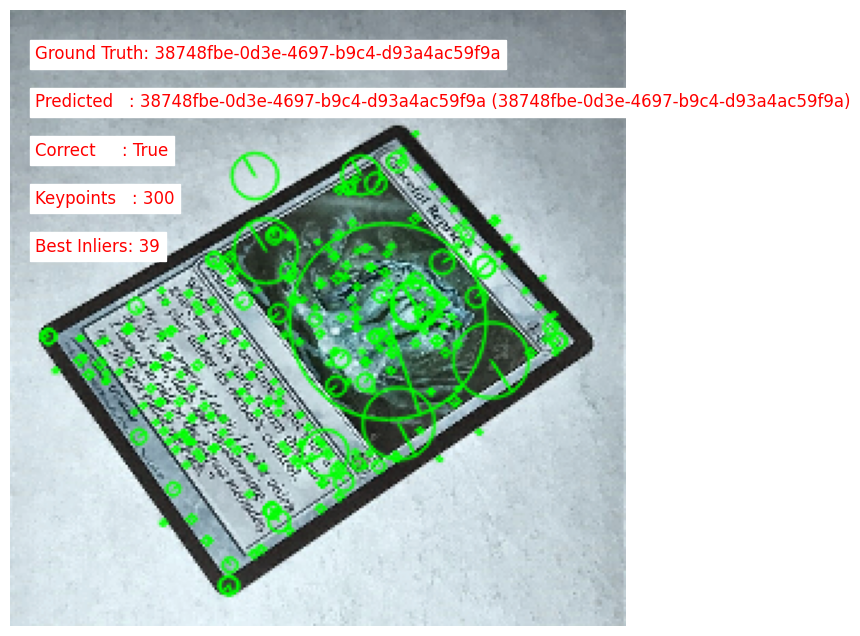

Evaluating images:  11%|█         | 1/9 [00:06<00:48,  6.11s/it]

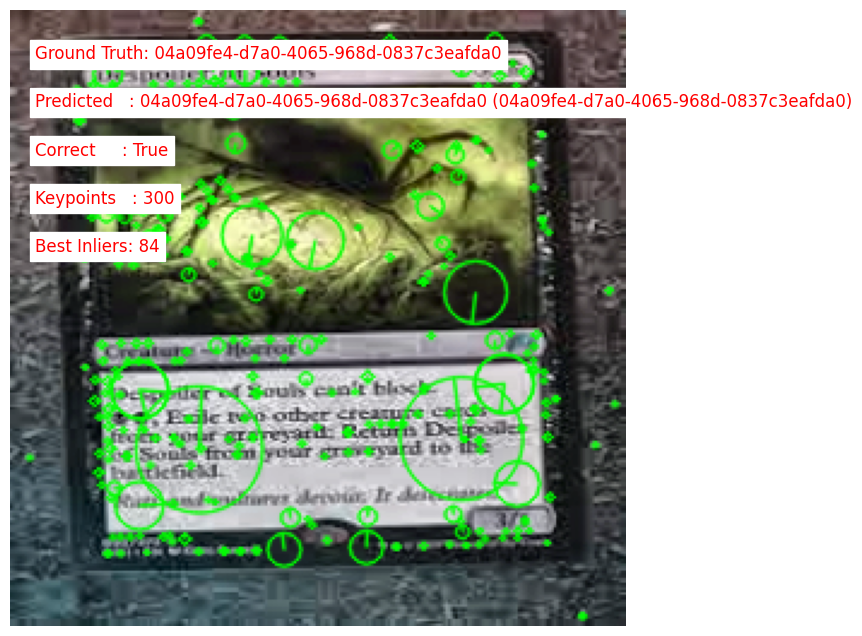

Evaluating images:  22%|██▏       | 2/9 [00:12<00:45,  6.45s/it]

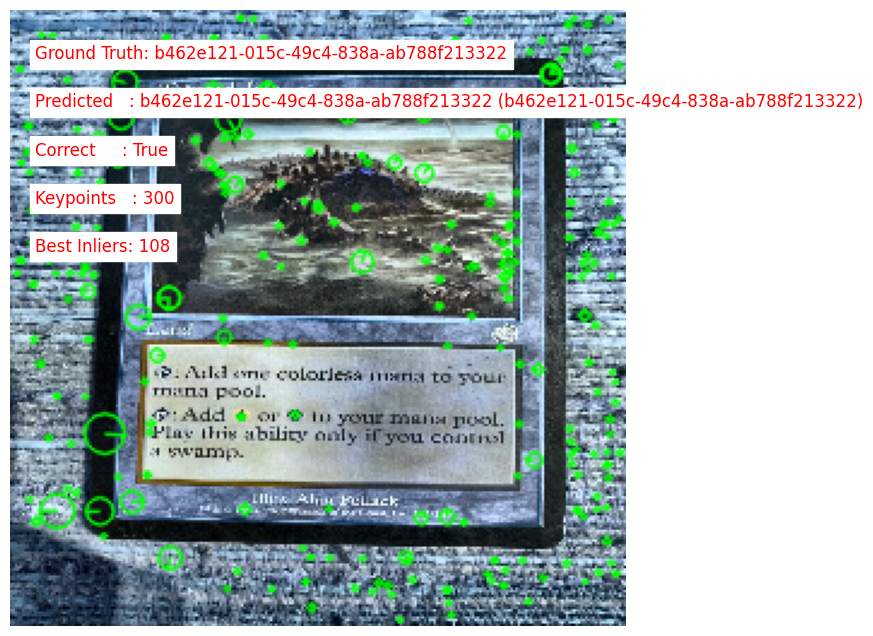

Evaluating images:  33%|███▎      | 3/9 [00:17<00:33,  5.60s/it]

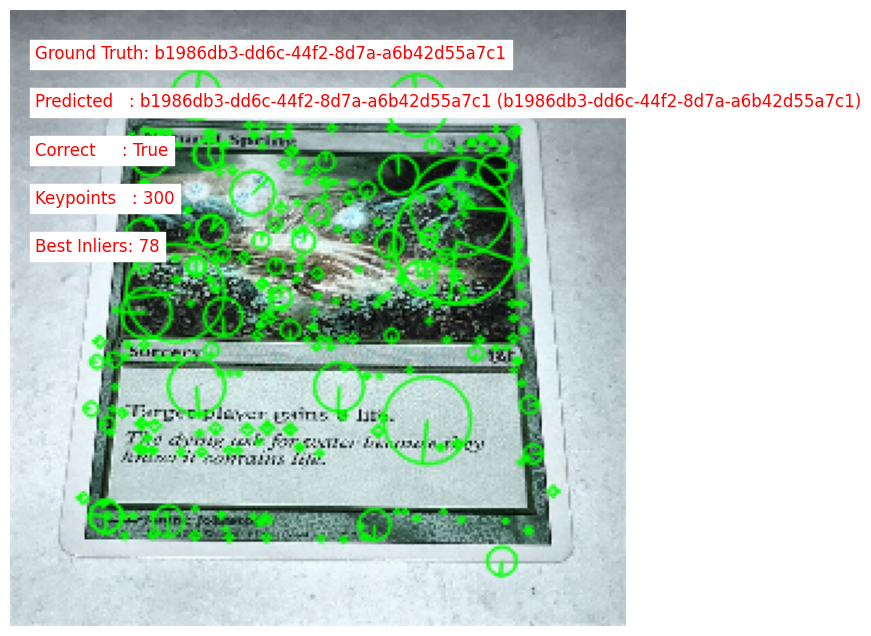

Evaluating images:  44%|████▍     | 4/9 [00:23<00:29,  5.94s/it]

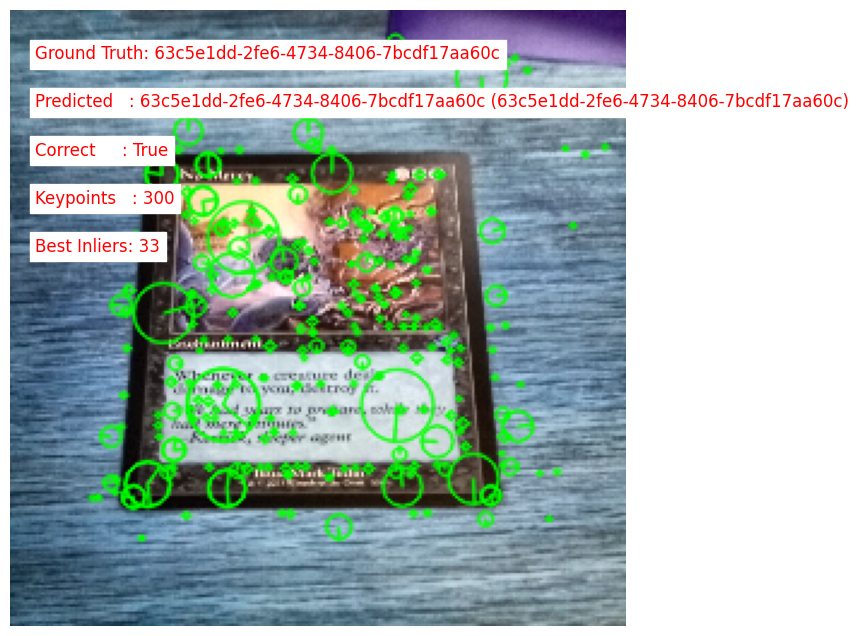

Evaluating images:  56%|█████▌    | 5/9 [00:29<00:23,  5.81s/it]

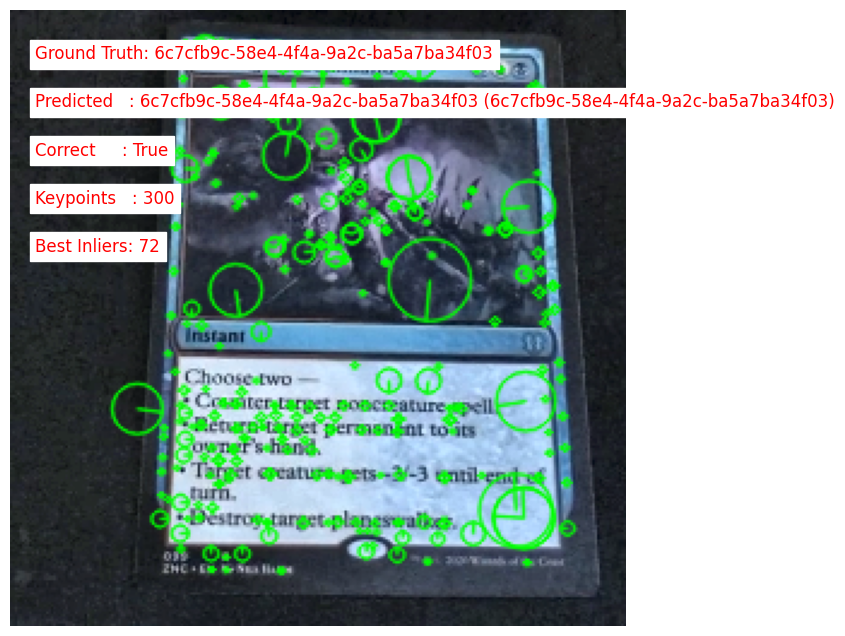

Evaluating images:  67%|██████▋   | 6/9 [00:36<00:18,  6.23s/it]

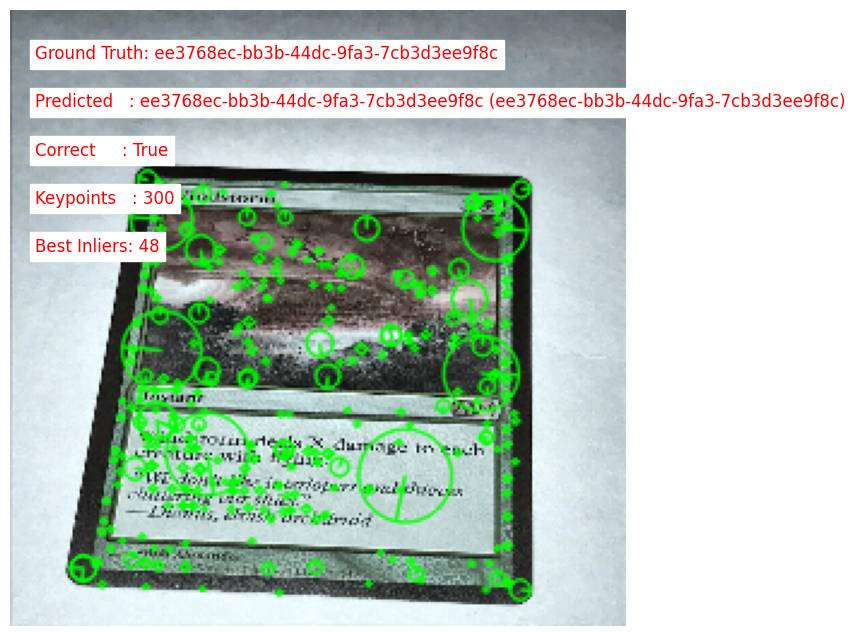

Evaluating images:  78%|███████▊  | 7/9 [00:41<00:11,  5.81s/it]

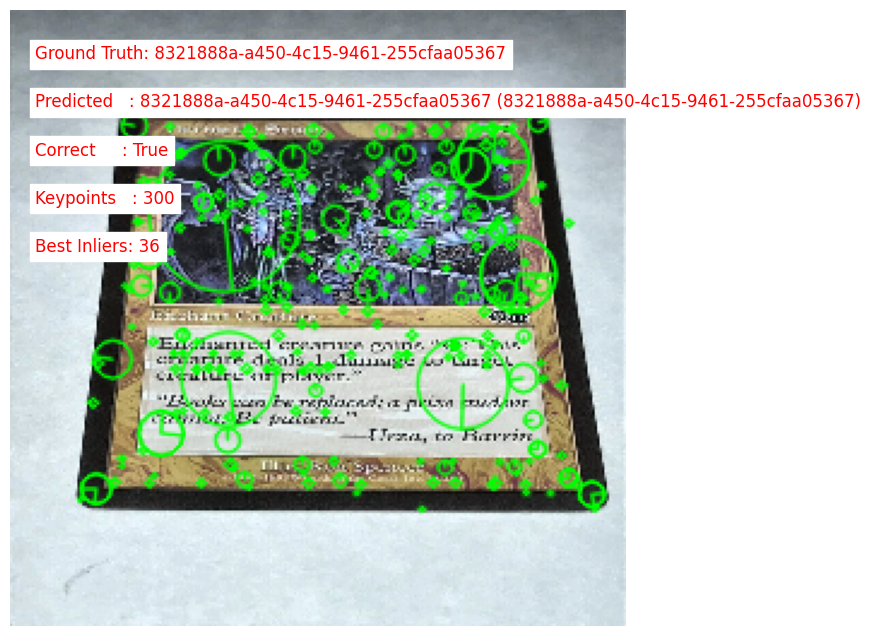

Evaluating images:  89%|████████▉ | 8/9 [00:45<00:05,  5.38s/it]

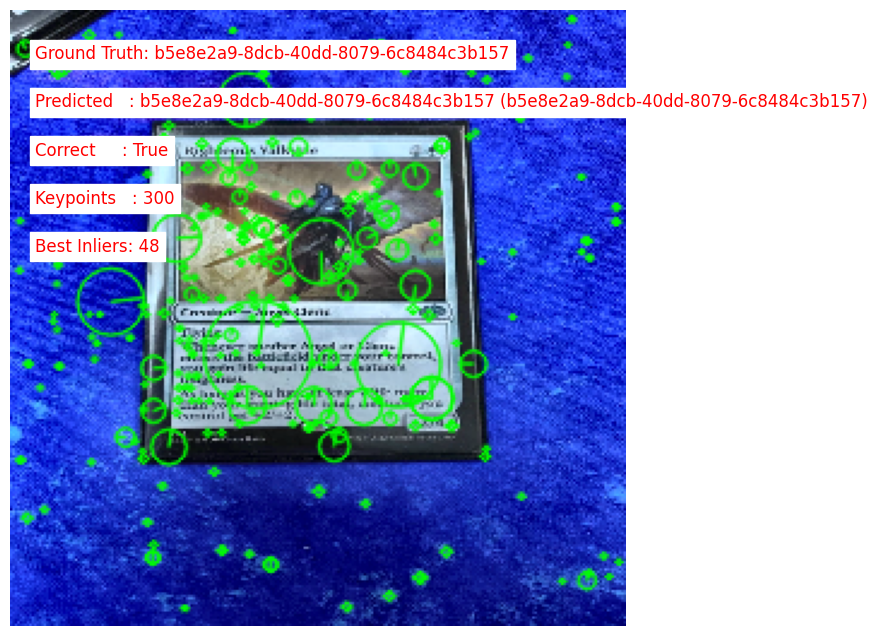

Evaluating images: 100%|██████████| 9/9 [00:50<00:00,  5.57s/it]

Overall Accuracy: 100.00% (9/9 correct)


In [ ]:
import cv2
import numpy as np
import json
import pandas as pd
import faiss
import matplotlib.pyplot as plt
import h5py
import sqlite3
from collections import Counter
from tqdm import tqdm

##############################
# Helper Functions for Candidate Features (HDF5)
##############################

def load_candidate_features_for_card(card_id, hf):
    """
    Given a card ID and an open HDF5 file (hf), load all candidate features for that card.
    Returns a list of tuples (kp_serialized, descriptors) with descriptors as float32.
    """
    features = []
    if card_id in hf:
        card_grp = hf[card_id]
        for feat_key in card_grp.keys():
            # Read keypoints stored as a JSON string.
            kp_json_arr = card_grp[feat_key]["keypoints"][()]
            kp_str = kp_json_arr[0].decode("utf-8") if isinstance(kp_json_arr[0], bytes) else kp_json_arr[0]
            kp_serialized = json.loads(kp_str)
            # Read descriptors (stored as float16, converted back to float32).
            des = card_grp[feat_key]["descriptors"][()].astype('float32')
            features.append((kp_serialized, des))
    return features

##############################
# SQLite Mapping Helper
##############################

def query_faiss_mapping(descriptor_indices, db_path='resources/run/card_database.db'):
    """
    Given a list of FAISS descriptor indices (from a FAISS search),
    query the SQLite mapping table ("faiss_mapping") and return a dictionary
    mapping each index to its corresponding scryfall_id.
    """
    if not descriptor_indices:
        return {}
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    placeholders = ','.join(['?'] * len(descriptor_indices))
    query = f"SELECT faiss_index, scryfall_id FROM faiss_mapping WHERE faiss_index IN ({placeholders})"
    cursor.execute(query, tuple(descriptor_indices))
    rows = cursor.fetchall()
    conn.close()
    mapping = {row[0]: row[1] for row in rows}
    return mapping

##############################
# Load Persistent Data
##############################

# Open the HDF5 file containing candidate features.
hf = h5py.File('resources/run/candidate_features.h5', 'r')

# Load label mapping from the SQLite "cards" table.
conn = sqlite3.connect('resources/run/card_database.db')
label_mapping = pd.read_sql_query("SELECT * FROM cards", conn)
conn.close()

# Load the FAISS index.
faiss_index = faiss.read_index("resources/run/faiss_ivf.index")

##############################
# Feature Extraction for Inference
##############################

def serialize_keypoints(keypoints):
    return [{
        'pt': kp.pt,
        'size': kp.size,
        'angle': kp.angle,
        'response': kp.response,
        'octave': kp.octave,
        'class_id': kp.class_id
    } for kp in keypoints]

def deserialize_keypoints(kps_data):
    keypoints = []
    for d in kps_data:
        kp = cv2.KeyPoint(d['pt'][0], d['pt'][1],
                          d['size'], d['angle'],
                          d['response'], d['octave'],
                          d['class_id'])
        keypoints.append(kp)
    return keypoints

def extract_features_sift(image_path, max_features=200):
    """
    For inference:
      1. Load the image and resize to 256x256.
      2. Convert to LAB, apply CLAHE on the L channel, then convert back to BGR.
      3. Convert to grayscale and extract SIFT features.
      4. Apply RootSIFT normalization.
    Returns keypoints, descriptors (as float32), and the preprocessed image.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Unable to read image {image_path}")
    
    resized = cv2.resize(image, (256,256))
    lab = cv2.cvtColor(resized, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    L_clahe = clahe.apply(L)
    lab_clahe = cv2.merge((L_clahe, A, B))
    enhanced_color = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)
    gray = cv2.cvtColor(enhanced_color, cv2.COLOR_BGR2GRAY)
    
    sift = cv2.SIFT_create(nfeatures=max_features)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    
    if descriptors is not None and len(keypoints) > max_features:
        sorted_kp_des = sorted(zip(keypoints, descriptors), key=lambda x: -x[0].response)
        keypoints, descriptors = zip(*sorted_kp_des[:max_features])
        keypoints, descriptors = list(keypoints), np.array(descriptors)
    
    if descriptors is not None:
        eps = 1e-7
        descriptors = descriptors / (descriptors.sum(axis=1, keepdims=True) + eps)
        descriptors = np.sqrt(descriptors)
        descriptors = descriptors.astype('float32')
    
    return keypoints, descriptors, enhanced_color

##############################
# Inference Functions
##############################

def find_closest_card_ransac(image_path, faiss_index, hf, label_mapping, k=5, mapping_db_path='resources/run/card_database.db'):
    """
    Extracts SIFT features from the test image, searches for candidate matches in the FAISS index,
    queries the SQLite mapping table ("faiss_mapping") to look up candidate card IDs,
    loads candidate features from HDF5 on-demand, and uses BFMatcher+RANSAC to pick the best candidate.
    Returns the best candidate card ID, a display name, keypoints, the processed image, and debug info.
    """
    debug_info = {}
    keypoints, descriptors, processed_img = extract_features_sift(image_path, max_features=300)
    debug_info['num_keypoints'] = len(keypoints) if keypoints else 0
    if descriptors is None or len(keypoints) == 0:
        debug_info['error'] = "No descriptors found."
        return None, "Unknown", keypoints, processed_img, debug_info

    descriptors = descriptors.astype('float32')
    distances, indices = faiss_index.search(descriptors, k)
    
    # Flatten indices and filter out any -1 entries.
    search_indices = [int(i) for i in indices.flatten() if i >= 0]
    mapping = query_faiss_mapping(search_indices, db_path=mapping_db_path)
    candidate_ids = [mapping[i] for i in search_indices if i in mapping]
    candidate_counts = Counter(candidate_ids)
    debug_info['faiss_candidate_counts'] = dict(candidate_counts)

    bf = cv2.BFMatcher()
    best_inliers = 0
    best_candidate = None

    for candidate_id in candidate_counts.keys():
        candidate_sets = load_candidate_features_for_card(candidate_id, hf)
        total_inliers = 0
        for kp_serialized, candidate_des in candidate_sets:
            candidate_kp = deserialize_keypoints(kp_serialized)
            matches = bf.knnMatch(descriptors, candidate_des.astype('float32'), k=2)
            good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
            if len(good_matches) >= 4:
                src_pts = np.float32([keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
                dst_pts = np.float32([candidate_kp[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
                H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
                if mask is not None:
                    inliers = int(mask.sum())
                    total_inliers += inliers
        debug_info.setdefault('ransac_inliers', {})[candidate_id] = total_inliers
        if total_inliers > best_inliers:
            best_inliers = total_inliers
            best_candidate = candidate_id

    debug_info['best_inliers'] = best_inliers

    try:
        card_row = label_mapping.loc[label_mapping['scryfall_id'] == best_candidate]
        card_name = best_candidate if not card_row.empty else "Unknown"
    except Exception:
        card_name = "Unknown"

    return best_candidate, card_name, keypoints, processed_img, debug_info

def visualize_keypoints_on_resized(image_path, keypoints, processed_img, annotations=None, figsize=(10,8)):
    """
    Displays the processed image with keypoints overlaid.
    If the processed image is missing, attempts to reload and resize the original image.
    """
    if processed_img is None or processed_img.size == 0:
        processed_img = cv2.imread(image_path)
        if processed_img is None:
            print("Error: Could not load image for visualization.")
            return
        processed_img = cv2.resize(processed_img, (256,256))
    image_with_kp = cv2.drawKeypoints(processed_img, keypoints, None,
                                      color=(0,255,0),
                                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=figsize)
    plt.imshow(image_with_kp, cmap='gray')
    plt.axis('off')
    if annotations:
        y0, dy = 20, 20
        for i, text in enumerate(annotations):
            plt.text(10, y0 + i * dy, text, color='red', fontsize=12, backgroundcolor='white')
    plt.show()

def evaluate_accuracy_ransac(test_csv, faiss_index, hf, label_mapping, k=5, mapping_db_path='resources/run/card_database.db'):
    """
    Evaluates inference accuracy using a CSV file (with 'image_path' and 'true_card_id').
    For each test image, the predicted card is compared to the ground truth, and results are visualized.
    """
    test_data = pd.read_csv(test_csv)
    total = len(test_data)
    correct = 0
    predictions = []

    for idx, row in tqdm(test_data.iterrows(), total=total, desc="Evaluating images"):
        image_path = row['image_path']
        true_card_id = row['true_card_id']
        try:
            predicted_id, predicted_name, keypoints, processed_img, debug_info = find_closest_card_ransac(
                image_path, faiss_index, hf, label_mapping, k, mapping_db_path)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            predicted_id = None
            predicted_name = "Unknown"
            keypoints = []
            processed_img = None
            debug_info = {"error": str(e)}
        
        is_correct = predicted_id == true_card_id
        if is_correct:
            correct += 1
        predictions.append((image_path, true_card_id, predicted_id, debug_info))
        
        annotation_lines = [
            f"Ground Truth: {true_card_id}",
            f"Predicted   : {predicted_id} ({predicted_name})",
            f"Correct     : {is_correct}",
            f"Keypoints   : {debug_info.get('num_keypoints', 'N/A')}",
            f"Best Inliers: {debug_info.get('best_inliers', 'N/A')}"
        ]
        visualize_keypoints_on_resized(image_path, keypoints, processed_img, annotations=annotation_lines)
    
    accuracy = (correct / total) * 100
    print(f"Overall Accuracy: {accuracy:.2f}% ({correct}/{total} correct)")
    return predictions, accuracy

##############################
# Example Usage
##############################

test_csv_path = "validation_images/test_dataset.csv"  # CSV with columns: image_path, true_card_id
predictions, accuracy = evaluate_accuracy_ransac(
    test_csv_path, faiss_index, hf, label_mapping, k=5, mapping_db_path='resources/run/card_database.db'
)

# Close the HDF5 file when done.
hf.close()
